In [10]:
import pandas as pd
import numpy as np

# Extending GRADIS by inclusion of promoter binding motifs

In [ ]:
# Loading datasets for E coli network
gold_df = pd.read_csv('../../files/data/DREAM5_GoldStandard_Network3-E-coli.tsv', sep='\t', header = None) 
gold_df.columns = ['TF', 'Target', 'Label']
expr_df = pd.read_csv('../../files/data/net3_expression_data.tsv', sep='\t') 
tfactors = pd.read_csv('../../files/data/net3_transcription_factors.tsv', sep='\t', header = None)

print(f'Shape of expression data: {expr_df.shape}')
print(f'Shape of gold standard data: {gold_df.shape}')
expr_df.head()

Shape of expression data: (805, 4511)
Shape of gold standard data: (152280, 3)


,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,...,G4502,G4503,G4504,G4505,G4506,G4507,G4508,G4509,G4510,G4511
0,7.1151,9.3293,9.5997,6.9998,7.4955,8.8540,9.6438,8.0483,7.8193,6.6930,...,8.8613,6.5512,11.596,10.2480,8.5339,7.6695,8.2989,6.4199,7.3635,9.9146
1,7.2840,9.2212,9.4961,6.8697,7.4101,8.8075,9.1561,8.3685,7.8133,6.9091,...,8.8243,6.6192,11.433,10.3490,8.8092,7.9183,8.2432,6.7346,7.3835,8.6026
2,6.6090,8.6310,10.2730,7.0817,7.5102,8.3077,9.2641,9.1081,7.2929,7.2205,...,8.6539,6.8997,10.300,9.8009,8.1606,7.8730,7.8048,6.6771,8.3439,8.6646
3,6.4579,8.7221,10.1430,7.0796,7.4146,8.2493,9.5136,8.9252,7.0312,7.0164,...,8.5712,5.8688,10.350,9.8552,8.1661,7.8176,7.7709,6.9012,8.2427,8.4744
4,6.6933,8.6554,10.0250,7.0943,7.5755,8.1735,9.3911,8.9831,7.0007,6.8017,...,8.4778,6.4563,10.558,9.7967,8.5144,7.6769,7.8688,6.7569,8.2085,9.0467


In [ ]:
# GRADIS implementation
# STEP 1: Sample clustering
from sklearn.cluster import KMeans

# Clustering is done by rows (samples). To reduce the samples to k clusters centroids.
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(expr_df)

# extract centroids (50 × 4511): each centroid = synthetic sample
centroids = kmeans.cluster_centers_  # Shape (50, 4511)

# Create reduced representation: genes × centroids (4511 × 50)
reduced_data = centroids.T  #Transpose to get 𝐱_g = (x_g¹, x_g², ..., x_g⁵⁰)


In [ ]:
# STEP 2: Construction of complete graph distance profiles

from scipy.spatial.distance import pdist
from sklearn.preprocessing import minmax_scale

# Scale expression profiles to [0,1] by gene (axis=1)
reduced_data_scaled = minmax_scale(reduced_data, axis=1) 

# Get gene names from expression data
gene_names = expr_df.columns.tolist()

# Create gene-to-index mapping for fast lookup
gene_to_idx = {gene: idx for idx, gene in enumerate(gene_names)}

# Feature matrix must be n_pairs × n_features
# where n_pairs is the number of pairs of TF and target genes, and n_features is
# the number of pairwise distances (k * (k - 1) / 2). k is number of centroids.
def build_features(gold_df, reduced_data_scaled, gene_to_idx):
    k = reduced_data_scaled.shape[1]
    n_features = k * (k - 1) // 2  # Number of pairwise distances
    
    X = np.zeros((len(gold_df), n_features))
    y = gold_df['Label'].values
    
    for i, row in gold_df.iterrows():
        tf = row['TF']
        target = row['Target']
        
        # Get indices for TF and target gene
        tf_idx = gene_to_idx.get(tf)
        target_idx = gene_to_idx.get(target)
        
        if tf_idx is None or target_idx is None:
            raise ValueError(f"Gene not found: TF={tf}, Target={target}")
        
        # Extract scaled expression profiles
        x_tf = reduced_data_scaled[tf_idx]  # Vector: (x_TF¹, x_TF², ..., x_TFᵏ)
        x_target = reduced_data_scaled[target_idx]  # Vector: (x_G¹, x_G², ..., x_Gᵏ)
        
        # Create k points in unit square: [(x_TFⁱ, x_Gⁱ)] for i=1..k
        points = np.column_stack((x_tf, x_target))  # Shape: (k, 2)
        
        # Compute pairwise Euclidean distances (upper triangle)
        X[i] = pdist(points, metric='euclidean')  # Or metric='cityblock'
    
    return X, y

# Generate feature matrix and labels
X_gold, y_gold = build_features(gold_df, reduced_data_scaled, gene_to_idx)

In [14]:
X_gold.shape, y_gold.shape  #((152280, 1225), (152280,))

((152280, 1225), (152280,))

In [ ]:
# STEP 3.1: SVM training and unknown set filtering

from sklearn.svm import SVC
from tqdm import tqdm

# Split indices for class 0 (unknown group) and class 1 (positive group)
indices_0 = np.where(y_gold == 0)[0]
indices_1 = np.where(y_gold == 1)[0]

# Shuffle class 0 indices for reproducibility
np.random.seed(42)
shuffled_indices_0 = np.random.permutation(indices_0)

# split points
spl = []
for i in range(0, len(shuffled_indices_0), len(indices_1)):
    spl.append(i)
spl.append(len(shuffled_indices_0))  # the last split to include remaining indices

# spl[70:] ==>>> [144620, 146686, 148752, 150214]

store_label = np.full(len(shuffled_indices_0), np.nan)

for i in tqdm(range(len(spl) - 1), desc="Processing folds"):
    # Define test and training indices
    ind_select = shuffled_indices_0[spl[i]:spl[i + 1]]
    ind_test = np.setdiff1d(shuffled_indices_0, ind_select)
    ind_train = np.concatenate([indices_1, ind_select])

    # Prepare training and testing data
    Data_Train = X_gold[ind_train, :]
    class_Train = y_gold[ind_train]
    Data_Test = X_gold[ind_test, :]

    # Train SVM classifier
    svm_clf = SVC(probability=True, random_state=42)
    svm_clf.fit(Data_Train, class_Train)
    
    # Predict labels for test set
    label = svm_clf.predict(Data_Test)

    # map labels to the original shuffled indices and get their indices
    _, label_ind, _ = np.intersect1d(shuffled_indices_0, ind_test, return_indices=True)
    store_label[label_ind] = label

# Identify indices predicted as negative by all classifiers
# filtered_neg_indices = shuffled_indices_0[store_label == 0]
# filtered_pos_indices = shuffled_indices_0[store_label == 1]


Processing folds: 100%|██████████| 73/73 [13:35:05<00:00, 669.94s/it]  


In [45]:
# Faster alternative, should be 50-100 times faster than SVC
# from sklearn.linear_model import SGDClassifier

# Classifier training with SGDClassifier
# fast_clf = SGDClassifier(loss='hinge', penalty='l2', max_iter=1000, random_state=42)
# fast_clf.fit(Data_Train, class_Train)

In [15]:
pos_df = pd.read_csv('net3_svm_positive_predictions.csv', index_col=0)
neg_df = pd.read_csv('net3_svm_negative_predictions.csv', index_col=0)

predicted_indices = np.concatenate([pos_df.index.values, neg_df.index.values])  # predicted indices
predicted_neg_indices = neg_df.index.values  # indices predicted as negative
predicted_pos_indices = pos_df.index.values  # indices predicted as positive

# Extract of predictions of negative and positive classes from the gold standard
neg_pred = gold_df.iloc[predicted_neg_indices]
pos_pred = gold_df.iloc[predicted_pos_indices]


In [ ]:
# STEP 3.2: Filter the negative set using my consensus table built from the databases
consensus_df = pd.read_csv('../../scripts/databases_data/combined_gene_tf.csv') #len = 2277

# Get the real gene names used in the gold standard
gene_ids = pd.read_csv('../../files/data/net3_gene_ids.tsv', sep='\t')
gene_ids.columns = ['GeneID', 'Gene'] # 4511 rows

# Create a modification of gene_ids to reflect the conventions of writing TFs
gene_ids['Gene'] = gene_ids.apply(
    lambda row: row['Gene'][0].upper() + row['Gene'][1:] 
    if row['GeneID'] in [f'G{i}' for i in range(1, 335)] 
    else row['Gene'], 
    axis=1
)

tf_cap = set(consensus_df[consensus_df['TF'].str.isupper()]['TF']) # {'CRP', 'FNR', 'H-NS', 'HU', 'IHF'}

gene_ids['Gene'] = gene_ids['Gene'].apply(
    lambda x: x.upper() 
    if x in ['Crp', 'Fnr', 'Hns', 'Hu', 'Ihf'] 
    else x
)

gene_ids.head()


,GeneID,Gene
0,G1,YneL
1,G2,NikR
2,G3,DnaA
3,G4,TdcA
4,G5,YhjB


In [17]:
# gene_ids.to_csv('net3_gene_ids_modified.tsv', sep='\t', index=False)

# replaced TFs and targets in the positive predictions with their real names
pos_pred.loc[:, 'TF'] = pos_pred['TF'].apply(
    lambda x: gene_ids.loc[gene_ids['GeneID'] == x, 'Gene'].values[0] 
    if x in gene_ids['GeneID'].values else x)

pos_pred.loc[:, 'Target'] = pos_pred['Target'].apply(
    lambda x: gene_ids.loc[gene_ids['GeneID'] == x, 'Gene'].values[0] 
    if x in gene_ids['GeneID'].values else x)   

# replaced TFs and targets in the negative predictions with their real names
neg_pred.loc[:, 'TF'] = neg_pred['TF'].apply(
    lambda x: gene_ids.loc[gene_ids['GeneID'] == x, 'Gene'].values[0] 
    if x in gene_ids['GeneID'].values else x)

neg_pred.loc[:, 'Target'] = neg_pred['Target'].apply(
    lambda x: gene_ids.loc[gene_ids['GeneID'] == x, 'Gene'].values[0] 
    if x in gene_ids['GeneID'].values else x)   

# pos_pred.to_csv('net3_mod_pos_pred.csv')
# neg_pred.to_csv('net3_mod_neg_pred.csv')


In [18]:
indices_1 = np.where(y_gold == 1)[0]
pos_reg = gold_df.iloc[indices_1]

pos_reg.loc[:, 'TF'] = pos_reg['TF'].apply(
    lambda x: gene_ids.loc[gene_ids['GeneID'] == x, 'Gene'].values[0] 
    if x in gene_ids['GeneID'].values else x)

pos_reg.loc[:, 'Target'] = pos_reg['Target'].apply(
    lambda x: gene_ids.loc[gene_ids['GeneID'] == x, 'Gene'].values[0] 
    if x in gene_ids['GeneID'].values else x)

# pos_reg.to_csv('net3_mod_pos_reg.csv', index_col=1) # index_col=1 to keep the GeneID as index

In [19]:
len(pos_pred), len(neg_pred), len(pos_reg)  #(30114, 120100, 2066)

(30114, 120100, 2066)

In [20]:
# Filter the negative predictions based on the consensus database

# Create set of lowercase tuples (TF, Target) from filtered consensus
consensus_set = set(zip(
    consensus_df['TF'].str.lower(),
    consensus_df['genes'].str.lower()
))

# Create aligned boolean mask using list comprehension
mask = [
    (tf.lower(), target.lower()) in consensus_set
    for tf, target in zip(neg_pred['TF'], neg_pred['Target'])
]

# Create result dataframe with original indices from neg_pred
false_neg_df = neg_pred.loc[mask, ['TF', 'Target']].copy()

# Remove the indices of the false negatives from the X_gold and y_gold
false_neg_indices = false_neg_df.index.values

X_gold_filtered = np.delete(X_gold, false_neg_indices, axis=0)
y_gold_filtered = np.delete(y_gold, false_neg_indices)

X_gold_filtered.shape, y_gold_filtered.shape    #((152029, 1225), (152029,))

((152029, 1225), (152029,))

In [ ]:
# STEP 3.4: SVM training on the filtered negative set
from sklearn.svm import SVC
from tqdm import tqdm

# Split indices for class 0 (unknown group) and class 1 (positive group)
indices_0 = np.where(y_gold_filtered == 0)[0]
indices_1 = np.where(y_gold_filtered == 1)[0]

# Shuffle class 0 indices for reproducibility
np.random.seed(42)
shuffled_indices_0 = np.random.permutation(indices_0)

# split points
spl = []
for i in range(0, len(shuffled_indices_0), len(indices_1)):
    spl.append(i)
spl.append(len(shuffled_indices_0))  

store_label_1 = np.full(len(shuffled_indices_0), np.nan)

for i in tqdm(range(len(spl) - 1), desc="Processing folds"):
    # Define test and training indices
    ind_select = shuffled_indices_0[spl[i]:spl[i + 1]]
    ind_test = np.setdiff1d(shuffled_indices_0, ind_select)
    ind_train = np.concatenate([indices_1, ind_select])

    # Prepare training and testing data
    Data_Train = X_gold_filtered[ind_train, :]
    class_Train = y_gold_filtered[ind_train]
    Data_Test = X_gold_filtered[ind_test, :]

    # Train SVM classifier
    svm_clf_final = SVC(probability=True, random_state=42)
    svm_clf_final.fit(Data_Train, class_Train)
    
    # Predict labels for test set
    label = svm_clf_final.predict(Data_Test)

    # map labels to the original shuffled indices and get their indices
    _, label_ind, _ = np.intersect1d(shuffled_indices_0, ind_test, return_indices=True)
    store_label_1[label_ind] = label


Processing folds: 100%|██████████| 73/73 [13:44:22<00:00, 677.56s/it]  


In [ ]:
# Identify indices predicted as negative by all classifiers of GRADIS_eX
predicted_neg_indices_grad_ex = shuffled_indices_0[store_label_1 == 0] #predicted negative indices
predicted_pos_indices_grad_ex = shuffled_indices_0[store_label_1 == 1] #predicted positive indices

# save these predictions and their indices
pos_df_ex = pd.DataFrame({
    'TF': gold_df.iloc[predicted_pos_indices_grad_ex]['TF'].values,
    'Target': gold_df.iloc[predicted_pos_indices_grad_ex]['Target'].values
}, index=predicted_pos_indices_grad_ex)

neg_df_ex = pd.DataFrame({
    'TF': gold_df.iloc[predicted_neg_indices_grad_ex]['TF'].values,
    'Target': gold_df.iloc[predicted_neg_indices_grad_ex]['Target'].values
}, index=predicted_neg_indices_grad_ex)

# pos_df_ex.to_csv('positive_predictions_ex.csv')
# neg_df_ex.to_csv('negative_predictions_ex.csv')

# (110755, 150214) previous values
len(predicted_neg_indices_grad_ex), len(predicted_neg_indices)

(110755, 120100)

# Evaluate GRADIS

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Ensure we have enough negative samples
n_pos = len(indices_1)
if len(predicted_neg_indices) == 0:
    print("Warning: No samples predicted negative by all classifiers.")
    
if len(predicted_neg_indices) > n_pos:
    subset_neg = np.random.choice(predicted_neg_indices, size=n_pos, replace=False) # replace=False ensures unique samples

X_balanced = np.concatenate([X_gold[indices_1], X_gold[subset_neg]])
y_balanced = np.concatenate([np.ones(n_pos), np.zeros(len(subset_neg))])  # 1 for positive, 0 for negative classes

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42)

# Train final GRADIS classifier
svm_clf_grad = SVC(probability=True, random_state=42)
svm_clf_grad.fit(X_train, y_train)

SVC(probability=True, random_state=42)

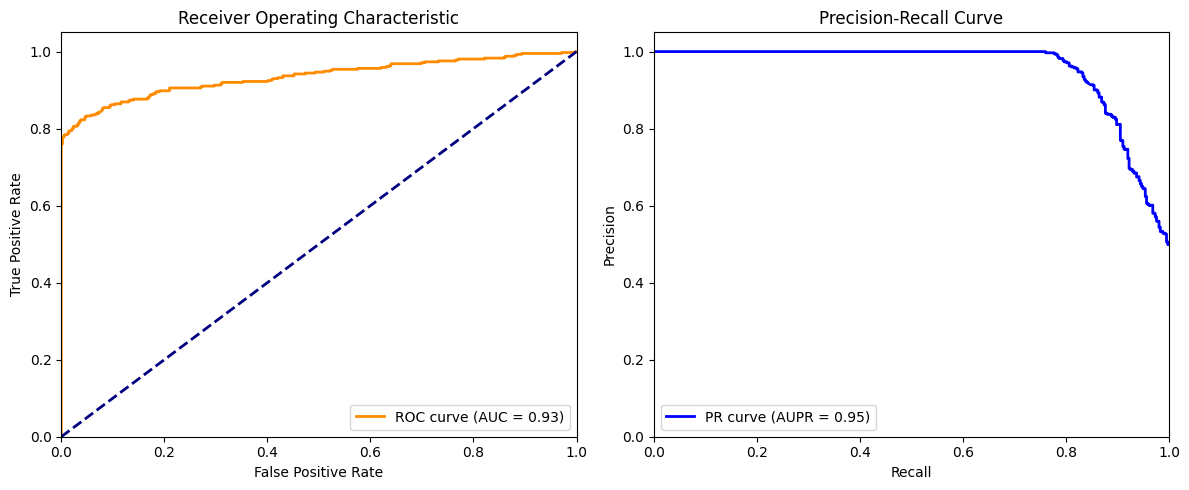

Test AUC: 0.934
Test AUPR: 0.954


In [28]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generate probability predictions
y_proba = svm_clf_grad.predict_proba(X_test)[:, 1]  # Probability of positive class

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve and AUPR
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)


# Plot ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, 
         label='PR curve (AUPR = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

print(f"Test AUC: {roc_auc:.3f}")
print(f"Test AUPR: {pr_auc:.3f}")

# Evaluate GRADIS_eX

In [33]:
# Ensure we have enough negative samples
n_pos = len(indices_1)
if len(predicted_neg_indices_grad_ex) == 0:
    print("Warning: No samples predicted negative by all classifiers.")
    
if len(predicted_neg_indices_grad_ex) > n_pos:
    subset_neg_ex = np.random.choice(predicted_neg_indices_grad_ex, size=n_pos, replace=False) # replace=False ensures unique samples

X_balanced_ex = np.concatenate([X_gold_filtered[indices_1], X_gold_filtered[subset_neg_ex]])
y_balanced_ex = np.concatenate([np.ones(n_pos), np.zeros(len(subset_neg_ex))])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced_ex, y_balanced_ex, test_size=0.2, stratify=y_balanced_ex, random_state=42)

# Train final GRADIS classifier
svm_clf_grad_ex = SVC(probability=True, random_state=42)
svm_clf_grad_ex.fit(X_train, y_train)

SVC(probability=True, random_state=42)

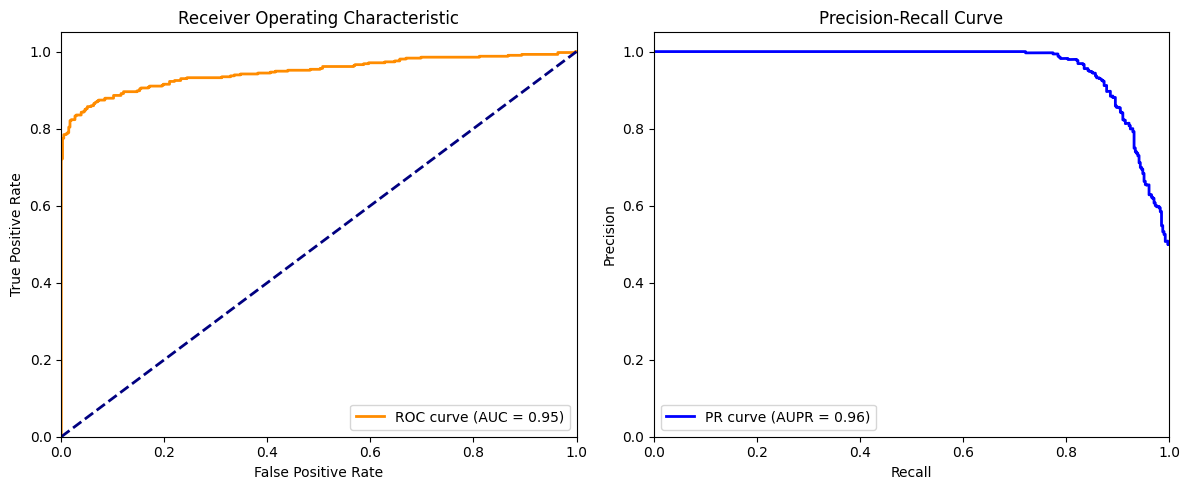

Test AUC: 0.947
Test AUPR: 0.963


In [34]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generate probability predictions
y_proba = svm_clf_grad_ex.predict_proba(X_test)[:, 1]  # Probability of positive class

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve and AUPR
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)


# Plot ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, 
         label='PR curve (AUPR = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

print(f"Test AUC: {roc_auc:.3f}")
print(f"Test AUPR: {pr_auc:.3f}")

# Evaluate a case where at least 2 data sources are positive

In [ ]:
# Step 1: Filter consensus_df for rows with at least two databases having value 1
condition = (consensus_df['regDB'] + consensus_df['shigen'] + consensus_df['ecocyc']) >= 2
filtered_consensus = consensus_df[condition]

# Create set of lowercase tuples (TF, Target) from filtered consensus
consensus_set2 = set(zip(
    filtered_consensus['TF'].str.lower(),
    filtered_consensus['genes'].str.lower()
))

# Create aligned boolean mask using list comprehension
mask = [
    (tf.lower(), target.lower()) in consensus_set2
    for tf, target in zip(neg_pred['TF'], neg_pred['Target'])
]

# Create result dataframe with original indices from neg_pred
false_neg_df2 = neg_pred.loc[mask, ['TF', 'Target']].copy()

# Remove the indices of the false negatives from the X_gold and y_gold
false_neg_indices2 = false_neg_df2.index.values

X_gold_filtered2 = np.delete(X_gold, false_neg_indices2, axis=0)
y_gold_filtered2 = np.delete(y_gold, false_neg_indices2)

X_gold_filtered2.shape, y_gold_filtered2.shape

((152131, 1225), (152131,))

In [42]:
len(filtered_consensus), len(consensus_df)

(1573, 2277)

In [ ]:
from sklearn.svm import SVC
from tqdm import tqdm

# Split indices for class 0 (unknown group) and class 1 (positive group)
indices_0 = np.where(y_gold_filtered2 == 0)[0]
indices_1 = np.where(y_gold_filtered2 == 1)[0]

# Shuffle class 0 indices for reproducibility
np.random.seed(42)
shuffled_indices_0 = np.random.permutation(indices_0)

# split points
# I have to figure out how to have 10 folds cross-validation
spl = []
for i in range(0, len(shuffled_indices_0), len(indices_1)):
    spl.append(i)
spl.append(len(shuffled_indices_0))  

store_label_2 = np.full(len(shuffled_indices_0), np.nan)

for i in tqdm(range(len(spl) - 1), desc="Processing folds"):
    # Define test and training indices
    ind_select = shuffled_indices_0[spl[i]:spl[i + 1]]
    ind_test = np.setdiff1d(shuffled_indices_0, ind_select)
    ind_train = np.concatenate([indices_1, ind_select])

    # Prepare training and testing data
    Data_Train = X_gold_filtered2[ind_train, :]
    class_Train = y_gold_filtered2[ind_train]
    Data_Test = X_gold_filtered2[ind_test, :]

    # Train SVM classifier
    svm_clf_final = SVC(probability=True, random_state=42)
    svm_clf_final.fit(Data_Train, class_Train)
    
    # Predict labels for test set
    label = svm_clf_final.predict(Data_Test)

    # map labels to the original shuffled indices and get their indices
    _, label_ind, _ = np.intersect1d(shuffled_indices_0, ind_test, return_indices=True)
    store_label_2[label_ind] = label


Processing folds: 100%|██████████| 73/73 [15:54:11<00:00, 784.26s/it]  


In [ ]:
# Identify indices predicted as negative by all classifiers of GRADIS_eX
predicted_neg_indices_grad_ex_2 = shuffled_indices_0[store_label_2 == 0] #predicted negative indices
predicted_pos_indices_grad_ex_2 = shuffled_indices_0[store_label_2 == 1] #predicted positive indices

# save these predictions and their indices
pos_df_ex2 = pd.DataFrame({
    'TF': gold_df.iloc[predicted_pos_indices_grad_ex_2]['TF'].values,
    'Target': gold_df.iloc[predicted_pos_indices_grad_ex_2]['Target'].values
}, index=predicted_pos_indices_grad_ex_2)

neg_df_ex2 = pd.DataFrame({
    'TF': gold_df.iloc[predicted_neg_indices_grad_ex_2]['TF'].values,
    'Target': gold_df.iloc[predicted_neg_indices_grad_ex_2]['Target'].values
}, index=predicted_neg_indices_grad_ex_2)

# pos_df_ex2.to_csv('positive_predictions_ex2.csv')
# neg_df_ex2.to_csv('negative_predictions_ex2.csv')

len(predicted_neg_indices_grad_ex_2), len(predicted_neg_indices_grad_ex), len(predicted_neg_indices)


(117659, 110755, 120100)

In [38]:
# Ensure we have enough negative samples
n_pos = len(indices_1)
if len(predicted_neg_indices_grad_ex_2) == 0:
    print("Warning: No samples predicted negative by all classifiers.")
    
if len(predicted_neg_indices_grad_ex_2) > n_pos:
    subset_neg_ex2 = np.random.choice(predicted_neg_indices_grad_ex_2, size=n_pos, replace=False) # replace=False ensures unique samples

X_balanced_ex2 = np.concatenate([X_gold_filtered2[indices_1], X_gold_filtered2[subset_neg_ex2]])
y_balanced_ex2 = np.concatenate([np.ones(n_pos), np.zeros(len(subset_neg_ex2))])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced_ex2, y_balanced_ex2, test_size=0.2, stratify=y_balanced_ex2, random_state=42)

# Train final GRADIS classifier
svm_clf_grad_ex2 = SVC(probability=True, random_state=42)
svm_clf_grad_ex2.fit(X_train, y_train)

SVC(probability=True, random_state=42)

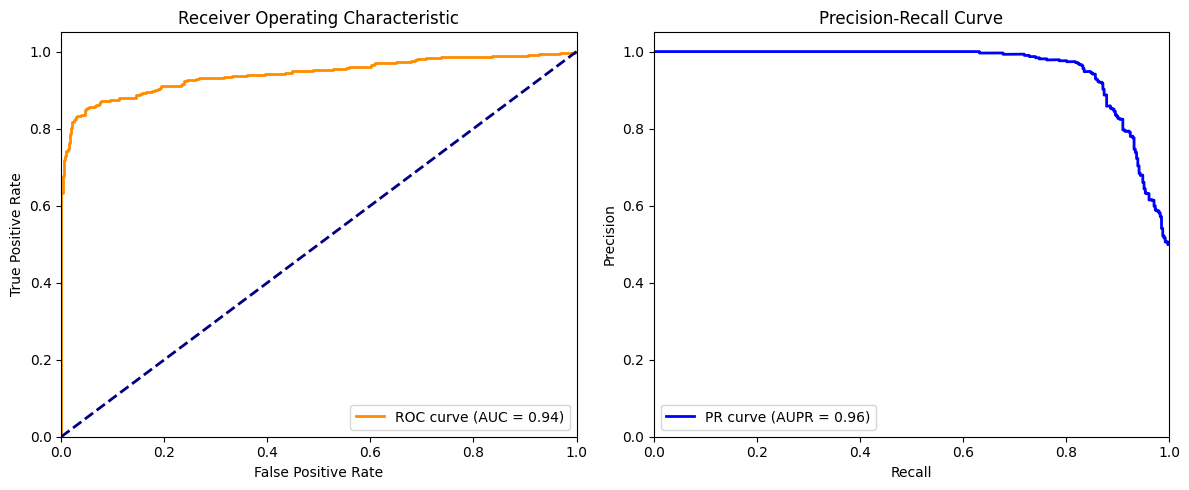

Test AUC: 0.942
Test AUPR: 0.958


In [39]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Generate probability predictions
y_proba = svm_clf_grad_ex.predict_proba(X_test)[:, 1]  # Probability of positive class

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Calculate Precision-Recall curve and AUPR
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)


# Plot ROC curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Plot Precision-Recall curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, 
         label='PR curve (AUPR = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

print(f"Test AUC: {roc_auc:.3f}")
print(f"Test AUPR: {pr_auc:.3f}")

In [1]:
# check the version of sklearn
import sklearn
print(sklearn.__version__)

1.4.2


In [ ]:
import numpy as np
import pandas as pd

# load data
pred_neg_df_ex = pd.read_csv('negative_predictions_ex.csv', index_col=0)
indices_1 = np.where(y_gold_filtered == 1)[0]
neg_indices_ex = pred_neg_df_ex.index.values

len(neg_indices_ex), len(indices_1) #(110755, 2066)

(110755, 2066)

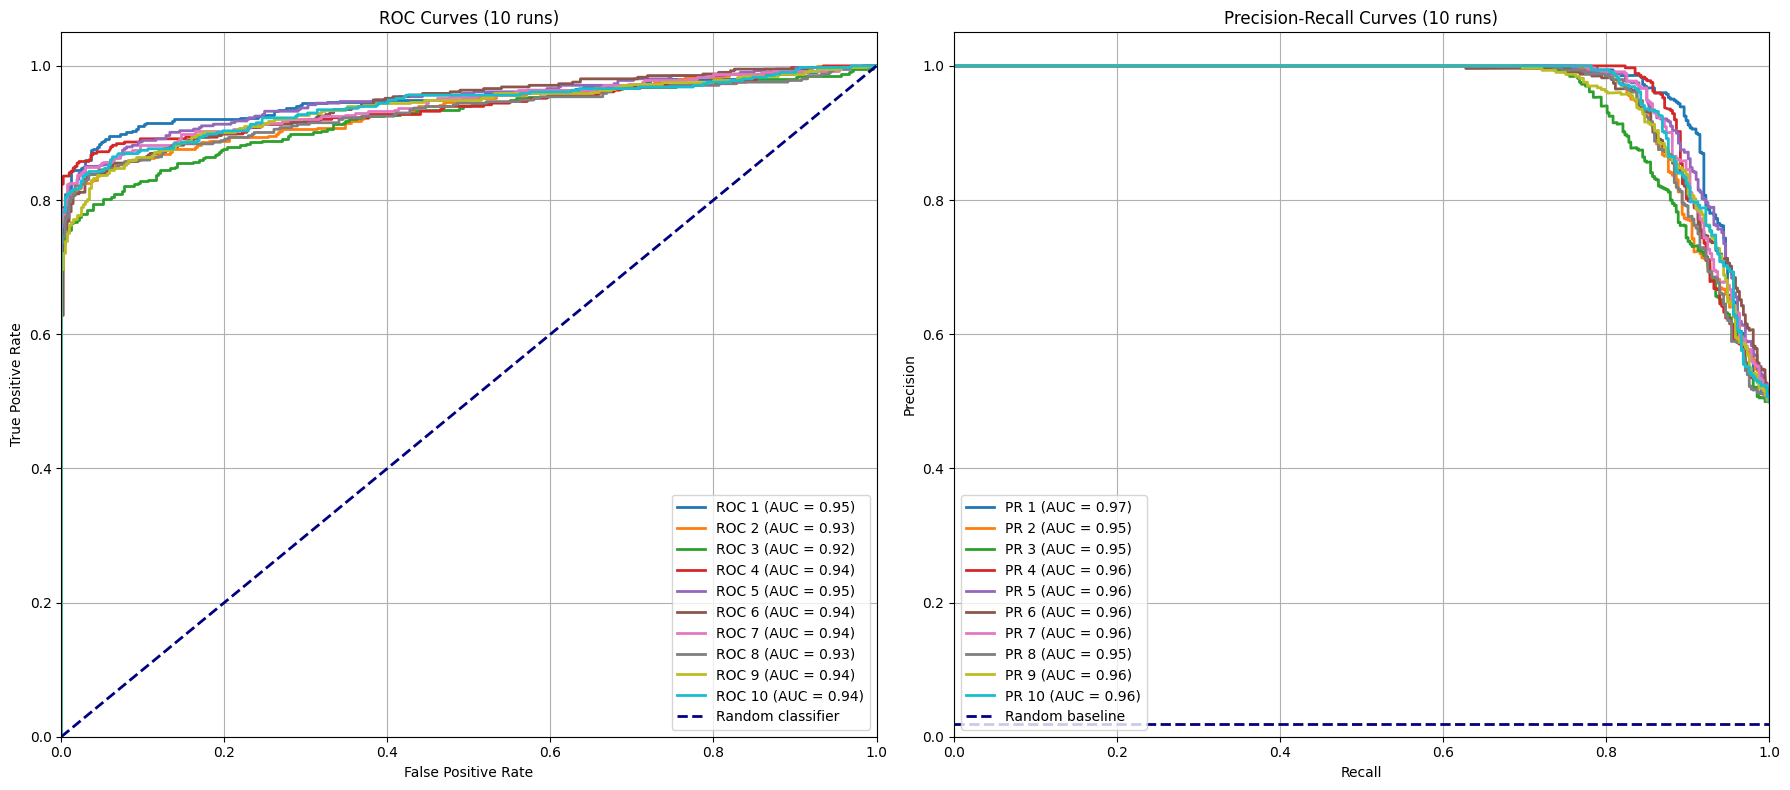

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Ensure we have enough negative samples
n_pos = len(indices_1)
if len(neg_indices_ex) == 0:
    print("Warning: No samples predicted negative by all classifiers.")

# Initialize lists to store performance metrics
all_roc_aucs = []
all_pr_aucs = []
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # Different colors for each curve

# Create figure with 2 plots (ROC and PR)
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for i in range(10):  # Create 10 different samples
    random_state = 42 + i
    np.random.seed(random_state)
    
    # Sample negative indices
    if len(neg_indices_ex) > n_pos:
        subset_neg_ex = np.random.choice(
            neg_indices_ex, 
            size=n_pos, 
            replace=False
        )
    else:
        subset_neg_ex = neg_indices_ex
        print(f"Iteration {i+1}: Using all {len(subset_neg_ex)} negative samples (fewer than positive samples)")
    
    # Create balanced dataset
    X_balanced_ex = np.concatenate([X_gold_filtered[indices_1], X_gold_filtered[subset_neg_ex]])
    y_balanced_ex = np.concatenate([np.ones(n_pos), np.zeros(len(subset_neg_ex))])
    
    # Split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_balanced_ex, y_balanced_ex, 
        test_size=0.2, 
        stratify=y_balanced_ex, 
        random_state=random_state
    )
    
    # Train SVM classifier
    svm_clf_grad_ex = SVC(probability=True, random_state=42)
    svm_clf_grad_ex.fit(X_train, y_train)
    
    # Generate probability predictions
    y_proba = svm_clf_grad_ex.predict_proba(X_test)[:, 1]
    
    # ROC curve + AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    all_roc_aucs.append(roc_auc)
    
    # PR curve + AUC
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    all_pr_aucs.append(pr_auc)
    
    # Plot ROC curve
    axes[0].plot(fpr, tpr, color=colors[i], lw=2, 
                 label=f'ROC {i+1} (AUC = {roc_auc:.2f})')
    
    # Plot PR curve
    axes[1].plot(recall, precision, color=colors[i], lw=2,
                 label=f'PR {i+1} (AUC = {pr_auc:.2f})')

# Add diagonal reference line for ROC
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves (10 runs)')
axes[0].legend(loc="lower right")
axes[0].grid(True)

# Add baseline for PR curve (proportion of positives)
baseline = n_pos / (n_pos + len(neg_indices_ex)) if len(neg_indices_ex) > 0 else 0
axes[1].plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random baseline')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves (10 runs)')
axes[1].legend(loc="lower left")
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# print summary statistics
print(f"Average ROC AUC: {np.mean(all_roc_aucs):.3f} (±{np.std(all_roc_aucs):.3f})")
print(f"Average PR AUC: {np.mean(all_pr_aucs):.3f} (±{np.std(all_pr_aucs):.3f})")
print(f"ROC AUC Range: {min(all_roc_aucs):.3f} - {max(all_roc_aucs):.3f}")
print(f"PR AUC Range: {min(all_pr_aucs):.3f} - {max(all_pr_aucs):.3f}")